# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from numpy import linalg as LA
from scipy.spatial.distance import pdist, squareform

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [3]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("e.krivenkov") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [76]:
class Cluster:
    def __init__(self, **kwargs):
        self.data = set()
        self.ind = -1
        
    def add_data(self, data):
        self.data |= data
        return self

class Clustering:
    def __init__(self, **kwargs):
        self.k = kwargs["k"]
        self.linkage = kwargs["linkage"]
        linkages = {"single":self.single_linkage, "complete":self.complete_linkage, "average":self.average_linkage}
        self.dist = linkages[self.linkage]
        return
    
    def single_linkage(self, cl_1, cl_2):
        dist = float("inf")
        for x in cl_1:
            for y in cl_2:
                dist = min(dist, self.dist_matrix[x, y])
                
        return dist
    
    def complete_linkage(self, cl_1, cl_2):
        dist = 0.0
        for x in cl_1:
            for y in cl_2:
                dist = max(dist, self.dist_matrix[x, y])
                
        return dist

    def average_linkage(self, cl_1, cl_2):
        dist = 0.0
        for x in cl_1:
            for y in cl_2:
                dist += self.dist_matrix[x, y]
                
        dist /= len(cl_1) * len(cl_2)
                
        return dist
    
    def fit(self, x, y=None):
        self.x_len = len(x)
        self.dist_matrix = squareform(pdist(x))
        self.clusters_vector = np.zeros(self.x_len, dtype=np.int64)
        return self
    
    def predict(self, x):
        n_clusters = self.x_len
        clusters = list()
        for i in range(self.x_len):
            cl = Cluster()
            cl.add_data({i})
            cl.ind = i
            clusters.append(cl)
            
        self.cluster_dist = self.dist_matrix

        while n_clusters > self.k:
            min_dist = float("inf")
            
            for i in range(n_clusters):
                for j in range(i + 1, n_clusters):
                    if self.cluster_dist[clusters[i].ind, clusters[j].ind] < min_dist:
                        min_dist = self.cluster_dist[clusters[i].ind, clusters[j].ind]
                        close_1 = i
                        close_2 = j
                        
            clusters[close_1].add_data(clusters[close_2].data)
            clusters.pop(close_2)
            
            n_clusters -= 1
            
            for i in range(close_1) + range(close_1 + 1, n_clusters):
                ind = clusters[close_1].ind
                data = clusters[close_1].data
                self.cluster_dist[ind, clusters[i].ind] = self.dist(data, clusters[i].data)
                self.cluster_dist[clusters[i].ind, ind] = self.cluster_dist[ind, clusters[i].ind]
                
            #if n_clusters % 100 == 0:
            #    print n_clusters
                
        for i in range(n_clusters):
            for element_index in clusters[i].data:
                self.clusters_vector[element_index] = i
        
        return self.clusters_vector
    
    def fit_predict(self, x, y=None):
        if (self.k == 1):
            return np.zeros(len(x), dtype=np.int64)
        else:
            self.fit(x, y)
            return self.predict(x)

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

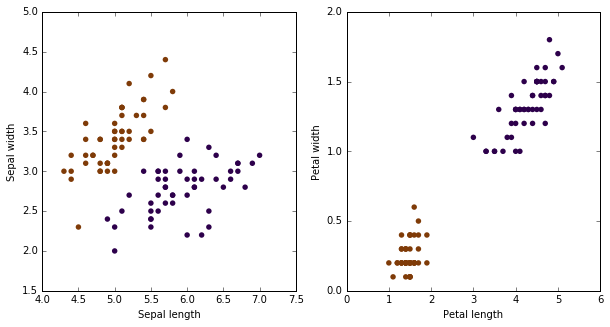

In [5]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [36]:
pred_iris = Clustering(k=2, linkage ="average").fit_predict(x_iris)
print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)

Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [31]:
def quality(x, y, k):
    x_len = len(x)
    dist_matrix = squareform(pdist(x))
    
    clusters_count = np.zeros(k)
    silhouette = 0.0
    
    for i in range(k):
        clusters_count[i] = np.count_nonzero(y == i)
    
    for i in range(x_len):
        mean_dist = np.zeros(k)
        b = float("inf")
        
        for j in range(x_len):
            mean_dist[y[j]] += dist_matrix[i, j]
            
        num = y[i]
        
        for j in range(num) + range(num + 1, k):
            mean_dist[j] /= clusters_count[j]
            b = min(b, mean_dist[j])
            
        if clusters_count[num] == 1:
            silhouette -= 1
        else:
            mean_dist[num] /= (clusters_count[num] - 1)
            a = mean_dist[num]
            silhouette += (b - a) / max(a, b)
        
    return silhouette / x_len
        

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

Clustering with k = 2
Clustering with k = 3
Clustering with k = 4
Clustering with k = 5
Clustering with k = 6
Clustering with k = 7
Clustering with k = 8
Clustering with k = 9
Clustering with k = 10


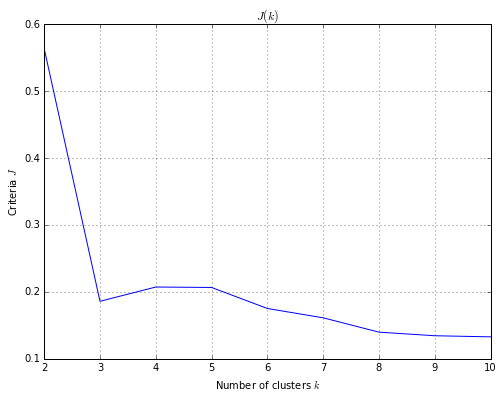

In [77]:
ks = range(2, 11)
criteria = np.zeros(len(ks))

sample = x[np.random.choice(x.shape[0], 2000)]

for i, k in enumerate(ks):
    print "Clustering with k = %d" % k
    cls = Clustering(k=k, linkage ="complete")
    y = cls.fit_predict(sample)
    criteria[i] = quality(sample, y, k)
    
pl.figure(figsize=(8, 6))
pl.plot(ks, criteria)
pl.title("$J(k)$")
pl.ylabel("Criteria $J$")
pl.xlabel("Number of clusters $k$")
pl.grid()
pl.show()

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

In [74]:
sample1 = x[np.random.choice(x.shape[0], len(x)/2)]
k = 2
cls1 = Clustering(k=k, linkage ="complete")
y1 = cls1.fit_predict(sample1)

KeyboardInterrupt: 

In [65]:
sample3 = x[np.random.choice(x.shape[0], len(x)/3)]
k = 2
cls3 = Clustering(k=k, linkage ="complete")
y3 = cls3.fit_predict(sample3)

3800
3700
3600
3500
3400
3300
3200
3100
3000
2900
2800
2700
2600
2500
2400
2300
2200
2100
2000
1900
1800
1700
1600
1500
1400
1300
1200
1100
1000
900
800
700
600
500
400
300
200
100


Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 3804
[t-SNE] Computed conditional probabilities for sample 2000 / 3804
[t-SNE] Computed conditional probabilities for sample 3000 / 3804
[t-SNE] Computed conditional probabilities for sample 3804 / 3804
[t-SNE] Mean sigma: 0.078027
[t-SNE] Error after 100 iterations with early exaggeration: 1.501008
[t-SNE] Error after 400 iterations: 1.311109


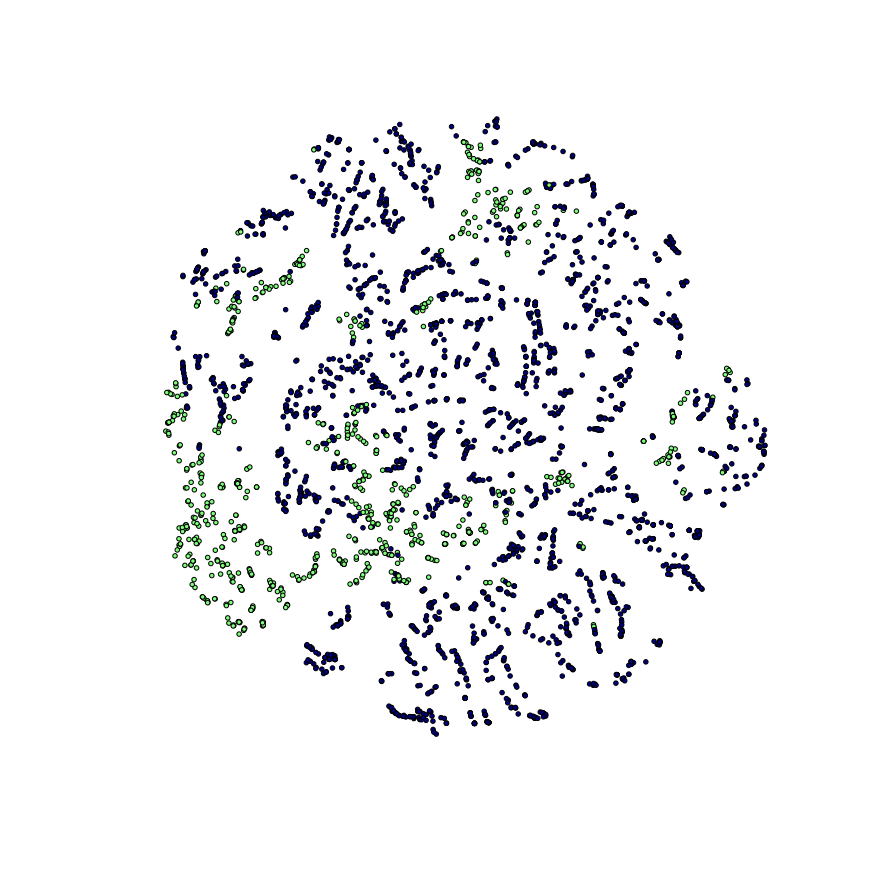

In [66]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(sample3)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y3))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

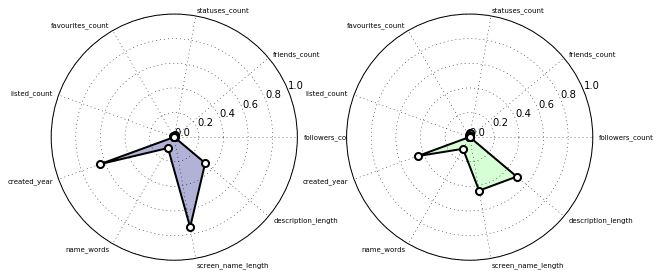

In [67]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y3)
for j, cluster in enumerate(clusters):    
    x_c = sample3[y3 == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.